In [1]:
import os
import json
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, auc


In [2]:
#;atplotlib con LaTex
from matplotlib import rc
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #Cargar paquetes de latex para usar sus funciones

# Process Experiment Results

This notebook generates the metrics and grpahs presented in the publication.

In [3]:
embeddings_metadata = {
    "bge-reranker-v2-m3" : {
        "params" : 0.568,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "BAAI/bge-reranker-v2-m3"
    },
    "bge-reranker-v2-m3---no-enhance" : {
        "params" : 0.568,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "BAAI/bge-reranker-v2-m3"
    },
    "gte-modernbert-base" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Alibaba-NLP/gte-modernbert-base"
    },
    "gte-modernbert-base---no-enhance" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Alibaba-NLP/gte-modernbert-base"
    },
    "gte-reranker-modernbert-base" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "Alibaba-NLP/gte-reranker-modernbert-base"
    },
    "gte-reranker-modernbert-base---no-enhance" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "Alibaba-NLP/gte-reranker-modernbert-base"
    },
    "jina-reranker-v2-base-multilingual" : {
        "params" : 0.278,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "jinaai/jina-reranker-v2-base-multilingual"
    },
    "jina-reranker-v2-base-multilingual---no-enhance" : {
        "params" : 0.278,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "jinaai/jina-reranker-v2-base-multilingual"
    },
    "multilingual-e5-large-instruct" : {
        "params" : 0.560,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "multilingual-e5-large-instruct---no-enhance" : {
        "params" : 0.560,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "multilingual-e5-large-instruct---no-instruct,no-enhance" : {
        "params" : 0.560,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "Qwen3-Embedding-0.6B" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-0.6B---no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-0.6B---no-instruct,no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-4B" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Embedding-4B---no-enhance" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Embedding-4B---no-instruct,no-enhance" : {
        "params" : 4,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Reranker-0.6B-seq-cls" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-0.6B-seq-cls"
    },
    "Qwen3-Reranker-0.6B-seq-cls---no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-0.6B-seq-cls"
    },
    "Qwen3-Reranker-4B-seq-cls" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-4B-seq-cls"
    },
    "Qwen3-Reranker-4B-seq-cls---no-enhance" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-4B-seq-cls"
    },
    "Qwen3-Reranker-8B-seq-cls" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-8B-seq-cls"
    },
    "Qwen3-Reranker-8B-seq-cls---no-enhance" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-8B-seq-cls"
    },
    "Qwen3-Embedding-8B" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
    "Qwen3-Embedding-8B---no-enhance" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
    "Qwen3-Embedding-8B---no-instruct,no-enhance" : {
        "params" : 8,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
}




In [4]:
renaming_rank_model_map = {
    "Qwen3-Reranker-8B-seq-cls":"Qwen3-Reranker-8B",
    "Qwen3-Reranker-4B-seq-cls":"Qwen3-Reranker-4B",
    "Qwen3-Reranker-0.6B-seq-cls":"Qwen3-Reranker-0.6B",
    "bge-reranker-v2-m3":"bge-reranker-v2-m3",
    "jina-reranker-v2-base-multilingual":"jina-reranker-v2-base-Multilingual",
    "gte-reranker-modernbert-base":"gte-reranker-modernbert-Base",
    "Qwen3-Embedding-8B":"Qwen3-Embedding-8B",
    "Qwen3-Embedding-4B":"Qwen3-Embedding-4B",
    "Qwen3-Embedding-0.6B":"Qwen3-Embedding-0.6B",
    "multilingual-e5-large-instruct":"multilingual-e5-large-instruct",
    "gte-modernbert-base":"gte-modernbert-base"
}

rename_llm_model_map = {
    'Meta-Llama-3-3-70B-Instruct-AWQ-INT4': 'Meta-Llama-3-3-70B-Instruct',
    'Qwen3-30B-A3B-GPTQ-Int4':'Qwen3-30B-A3B',
    'gpt-oss-20b': 'gpt-oss-20b'
}

In [5]:
DATA_PATH = f'../data/exploratory_analysis/'
TAGS_PATH = f'../data/implemented/'
BASELINES_PATH = f'../data/baselines/'

BEST_MODEL = "Qwen3-Reranker-8B-seq-cls"
BEST_IS_INSTRUCTED = True
BEST_IS_RERANKER = True
BEST_IS_ENHANCED = True

SAVE_FIGURES = True
OUTPUT_PATH_FIGURES = './output'
label_size = 20
title_size = 36
legend_size = 18

In [6]:
if SAVE_FIGURES:
    if not os.path.exists(OUTPUT_PATH_FIGURES):
        os.makedirs(OUTPUT_PATH_FIGURES)

### Load human tags

In [7]:
tags_rows = list()
for lm_dir in os.listdir(TAGS_PATH):
    model_path = os.path.join(TAGS_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    tags_path = os.path.join(TAGS_PATH, lm_dir, "human_labels.jsonl")
    # Read all lines
    with open(tags_path, 'r') as f:
        for i, line in enumerate(f):
            obj = json.loads(line)
            tags_rows.append(
                [
                    lm_dir,
                    obj["dataset_task"],
                    obj["line"],
                    obj["label"]=="Correct",
                ]
            )
tags_df = pd.DataFrame(tags_rows, columns=["language_model", "dataset_task", "prompt_idx", "human_tag"])
print(f"Read {len(tags_df)} tagged samples")

Read 17150 tagged samples


In [8]:
tags_df.head()

,language_model,dataset_task,prompt_idx,human_tag
0,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False
1,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,11,False
2,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,12,True
3,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,13,True
4,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,14,False


### Load exploratory tests

In [9]:
data_rows = list()
# For each embedding model tested

for emb_model_dir in tqdm(os.listdir(DATA_PATH), total=len(os.listdir(DATA_PATH))):
    emb_path = os.path.join(DATA_PATH, emb_model_dir)
    if not os.path.isdir(emb_path):
        continue
    # For each LM tested
    for lm_dir in os.listdir(emb_path):
        # For each results file
        model_path = os.path.join(emb_path, lm_dir)
        for result_file in os.listdir(model_path):
            if ".jsonl" not in result_file:
                continue
            # Read all lines
            with open(os.path.join(model_path, result_file), 'r') as f:
                for i, line in enumerate(f):
                    obj = json.loads(line)
                    # Get model metadata
                    model_metadata = embeddings_metadata[emb_model_dir]
                    # Add entry
                    data_rows.append(
                        [
                            model_metadata["huggingface_name"].split("/")[-1],
                            model_metadata["params"],
                            model_metadata["instruction_applied"],
                            model_metadata["reranker"],
                            model_metadata["a-vert_enhance"],
                            lm_dir,
                            int(np.ceil(len(obj["resps"][0][0].split(" "))*0.75)),
                            int(np.ceil(len(obj["arguments"]["gen_args_0"]["arg_0"][0].split(" "))*0.75)),                            
                            result_file.split('_2025')[0].split('samples_')[-1],
                            obj["doc_id"],
                            obj["a-vert_match"],
                            obj["a-vert_correct_score"],
                            obj["a-vert_wrong_score"],
                            obj["semscore"],
                        ]
                    )
                    
data_df = pd.DataFrame(data_rows, columns=["embedding_model", 
                                           "params_billons",
                                           "instruction_applied",
                                           "reranker",
                                           "enhance",
                                           "language_model", 
                                           "aprox_output_tokens", 
                                           "aprox_input_tokens",                                            
                                           "dataset_task", 
                                           "prompt_idx", 
                                           "a-vert_match", 
                                           "a-vert_correct_score", 
                                           "a-vert_wrong_score", 
                                           "semscore"])
print(f"Read {len(data_df)} experiment samples")

100%|██████████| 26/26 [00:16<00:00,  1.59it/s]


Read 709800 experiment samples


In [10]:
data_df.head()

,embedding_model,params_billons,instruction_applied,reranker,enhance,language_model,aprox_output_tokens,aprox_input_tokens,dataset_task,prompt_idx,a-vert_match,a-vert_correct_score,a-vert_wrong_score,semscore
0,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,38,175,mmlu_professional_law_chat_generative,0,False,0.496184,0.503816,0.0
1,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,117,191,mmlu_professional_law_chat_generative,1,False,0.491913,0.508087,0.0
2,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,37,114,mmlu_professional_law_chat_generative,2,True,0.509055,0.490945,0.0
3,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,203,111,mmlu_professional_law_chat_generative,3,True,0.511919,0.488081,0.0
4,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,187,122,mmlu_professional_law_chat_generative,4,False,0.492083,0.507917,0.0


### Combine experiment data with tags

In [11]:
merged_df = pd.merge(tags_df, data_df, on=['language_model', 'dataset_task', 'prompt_idx'])
# Create a column where the human tag and a-vert agree
merged_df["agree"] = merged_df["human_tag"]==merged_df["a-vert_match"]
print(f"Total number of test samples tagged: {len(merged_df)}\n")
print("Samples per LM:")
print(merged_df['language_model'].value_counts())
print("")
print("Samples per embedding/reranker:")
print(merged_df['embedding_model'].value_counts())


Total number of test samples tagged: 445900

Samples per LM:
language_model
Meta-Llama-3-3-70B-Instruct-AWQ-INT4    161980
Qwen3-30B-A3B-GPTQ-Int4                 141960
gpt-oss-20b                             141960
Name: count, dtype: int64

Samples per embedding/reranker:
embedding_model
Qwen3-Embedding-8B                    51450
Qwen3-Embedding-0.6B                  51450
multilingual-e5-large-instruct        51450
Qwen3-Embedding-4B                    51450
gte-reranker-modernbert-base          34300
gte-modernbert-base                   34300
Qwen3-Reranker-4B-seq-cls             34300
Qwen3-Reranker-0.6B-seq-cls           34300
jina-reranker-v2-base-multilingual    34300
Qwen3-Reranker-8B-seq-cls             34300
bge-reranker-v2-m3                    34300
Name: count, dtype: int64


In [12]:
def get_type(row):
    _,row=row
    if "babi" in row['dataset_task']:
        return "bAbI / open-ended"
    else:
        return "MMLU / multiple-choice"
    
merged_df['task_type'] = [get_type(a) for a in merged_df.iterrows()]

In [13]:
merged_df.head()

,language_model,dataset_task,prompt_idx,human_tag,embedding_model,params_billons,instruction_applied,reranker,enhance,aprox_output_tokens,aprox_input_tokens,a-vert_match,a-vert_correct_score,a-vert_wrong_score,semscore,agree,task_type
0,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,gte-reranker-modernbert-base,0.15,False,True,False,60,26,False,0.497225,0.502775,0.000000,True,bAbI / open-ended
1,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-8B,8.00,False,False,False,60,26,False,0.466189,0.533811,0.000000,True,bAbI / open-ended
2,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-0.6B,0.60,True,False,False,60,26,False,0.463396,0.536604,0.562774,True,bAbI / open-ended
3,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Reranker-4B-seq-cls,4.00,True,True,True,60,26,False,0.173490,0.826510,0.562786,True,bAbI / open-ended
4,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-0.6B,0.60,True,False,True,60,26,True,0.505671,0.494329,0.562774,False,bAbI / open-ended


In [14]:
def calculate_metrics(df):
    true_labels_binary = df['human_tag']
    predicted_labels_binary = df['a-vert_match']

    precision = precision_score(true_labels_binary, predicted_labels_binary)
    recall = recall_score(true_labels_binary, predicted_labels_binary)
    f1 = f1_score(true_labels_binary, predicted_labels_binary)
    specificity = recall_score(1-true_labels_binary, 1-predicted_labels_binary)
    balanced_accuracy = balanced_accuracy_score(true_labels_binary, predicted_labels_binary)

    return precision, recall, f1, specificity, balanced_accuracy

accurracy_compare_rows = list()
for model in list(merged_df['embedding_model'].unique()):
    for with_instrct in [True, False]:
        for with_enhance in [True, False]:
            for is_reranker in [True, False]:
                this_df = merged_df.loc[merged_df["embedding_model"] == model]
                this_df = this_df.loc[this_df["instruction_applied"] == with_instrct]
                if len(this_df) == 0 :
                    continue
                this_df = this_df.loc[this_df["enhance"] == with_enhance]
                if len(this_df) == 0 :
                    continue
                this_df = this_df.loc[this_df["reranker"] == is_reranker]
                if len(this_df) == 0 :
                    continue

                
                if with_instrct and with_enhance:
                    config_string = "instruction + enhance"
                elif with_instrct and not with_enhance:
                    config_string = "instruction"
                elif not with_instrct and with_enhance:
                    config_string = "enhance"
                else:
                    config_string = "base"
                
                # Compute
                precision, recall, f1, specificity, balanced_accuracy = calculate_metrics(this_df)
                # Track
                accurracy_compare_rows.append(
                    [
                        config_string,
                        model,
                        this_df["params_billons"].unique()[0],
                        with_instrct,
                        with_enhance,
                        is_reranker,
                        precision, 
                        recall, 
                        f1, 
                        specificity, 
                        balanced_accuracy
                    ]
                )
accurracy_compare_df = pd.DataFrame(accurracy_compare_rows, columns=[
                        "\nConfiguration:",
                        "Model:",
                        "params",
                        "with_instrct",
                        "with_enhance",
                        "is_reranker",
                        "precision", 
                        "recall", 
                        "f1", 
                        "specificity", 
                        "balanced_accuracy"
                    ])

# Plots

In [15]:
# # from accurracy_compare_df["Model:"] map the value into a new colum name "model_renamed" by taking the value from renaming_model_map
accurracy_compare_df["model_renamed"] = accurracy_compare_df["Model:"].map(renaming_rank_model_map)
accurracy_compare_df["ModelOriginal:"] = accurracy_compare_df["Model:"]
accurracy_compare_df["Model:"] = accurracy_compare_df["model_renamed"]

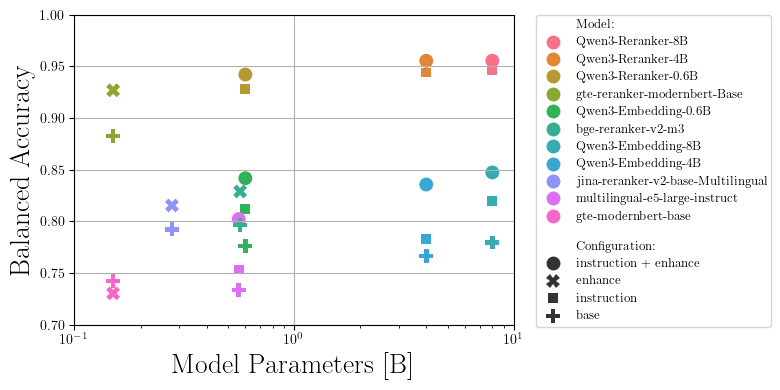

In [16]:
plt.figure(figsize=(8, 4))
scatter = sns.scatterplot(data=accurracy_compare_df, 
                          x="params", 
                          y="balanced_accuracy", 
                          hue='Model:', 
                          hue_order=[
                                renaming_rank_model_map["Qwen3-Reranker-8B-seq-cls"],
                                renaming_rank_model_map["Qwen3-Reranker-4B-seq-cls"],
                                renaming_rank_model_map["Qwen3-Reranker-0.6B-seq-cls"],
                                renaming_rank_model_map["gte-reranker-modernbert-base"],
                                renaming_rank_model_map["Qwen3-Embedding-0.6B"],
                                renaming_rank_model_map["bge-reranker-v2-m3"],
                                renaming_rank_model_map["Qwen3-Embedding-8B"],
                                renaming_rank_model_map["Qwen3-Embedding-4B"],
                                renaming_rank_model_map["jina-reranker-v2-base-multilingual"],
                                renaming_rank_model_map["multilingual-e5-large-instruct"],
                                renaming_rank_model_map["gte-modernbert-base"],
                                ],
                          style='\nConfiguration:', 
                          style_order=["instruction + enhance", "enhance", "instruction", "base"],
                          linewidth=0,
                          s=100)
plt.ylim(0.70,1.0)
plt.xlim(0.1,10.0)
plt.grid()
plt.xlabel("Model Parameters [B]", size=label_size)
plt.ylabel("Balanced Accuracy", size=label_size)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 9})
plt.xscale('log')
plt.tight_layout()
if SAVE_FIGURES:
      plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, 'all_embeddings.png'))
      plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, 'all_embeddings.pdf'),dpi=300)
      plt.draw()
else:
      plt.title('Balanced accuracy of different Embedding and Reranker models', size=title_size)
plt.show()

In [17]:
accurracy_compare_df.sort_values("balanced_accuracy", ascending=False)

,\nConfiguration:,Model:,params,with_instrct,with_enhance,is_reranker,precision,recall,f1,specificity,balanced_accuracy,model_renamed,ModelOriginal:
22,instruction + enhance,Qwen3-Reranker-8B,8.000,True,True,True,0.983866,0.987344,0.985602,0.923819,0.955582,Qwen3-Reranker-8B,Qwen3-Reranker-8B-seq-cls
8,instruction + enhance,Qwen3-Reranker-4B,4.000,True,True,True,0.984570,0.983456,0.984012,0.927478,0.955467,Qwen3-Reranker-4B,Qwen3-Reranker-4B-seq-cls
23,instruction,Qwen3-Reranker-8B,8.000,True,False,True,0.982394,0.974406,0.978384,0.917831,0.946119,Qwen3-Reranker-8B,Qwen3-Reranker-8B-seq-cls
9,instruction,Qwen3-Reranker-4B,4.000,True,False,True,0.982647,0.968891,0.975721,0.919494,0.944193,Qwen3-Reranker-4B,Qwen3-Reranker-4B-seq-cls
18,instruction + enhance,Qwen3-Reranker-0.6B,0.600,True,True,True,0.983229,0.961609,0.972299,0.922821,0.942215,Qwen3-Reranker-0.6B,Qwen3-Reranker-0.6B-seq-cls
19,instruction,Qwen3-Reranker-0.6B,0.600,True,False,True,0.981724,0.938066,0.959398,0.917831,0.927948,Qwen3-Reranker-0.6B,Qwen3-Reranker-0.6B-seq-cls
0,enhance,gte-reranker-modernbert-Base,0.150,False,True,True,0.981223,0.938419,0.959344,0.915502,0.926961,gte-reranker-modernbert-Base,gte-reranker-modernbert-base
1,base,gte-reranker-modernbert-Base,0.150,False,False,True,0.977961,0.856476,0.913196,0.909182,0.882829,gte-reranker-modernbert-Base,gte-reranker-modernbert-base
2,instruction + enhance,Qwen3-Embedding-8B,8.000,True,True,False,0.968802,0.818934,0.887586,0.875915,0.847424,Qwen3-Embedding-8B,Qwen3-Embedding-8B
5,instruction + enhance,Qwen3-Embedding-0.6B,0.600,True,True,False,0.965859,0.820065,0.887011,0.863606,0.841836,Qwen3-Embedding-0.6B,Qwen3-Embedding-0.6B


# Table for Paper

In [18]:
# remove repetition from 'ModelOriginal:', but keeping the first occurence
accurracy_compare_latex = accurracy_compare_df.sort_values("balanced_accuracy", ascending=False).drop_duplicates(subset=['ModelOriginal:'], keep='first')
# now sort accurracy_compare_latex by `is_reranker`, then by `params`
accurracy_compare_latex = accurracy_compare_latex.sort_values(["is_reranker", "params"], ascending=False)
# keep only the following columns in the specified order
latex_cols = ['is_reranker','model_renamed', 'params','precision', 'recall', 'f1', 'balanced_accuracy']
accurracy_compare_latex = accurracy_compare_latex[latex_cols]
accurracy_compare_latex = accurracy_compare_latex.round(3)
print(accurracy_compare_latex.to_latex(index=False,float_format="%.3f"))


\begin{tabular}{rlrrrrr}
\toprule
is_reranker & model_renamed & params & precision & recall & f1 & balanced_accuracy \\
\midrule
True & Qwen3-Reranker-8B & 8.000 & 0.984 & 0.987 & 0.986 & 0.956 \\
True & Qwen3-Reranker-4B & 4.000 & 0.985 & 0.983 & 0.984 & 0.955 \\
True & Qwen3-Reranker-0.6B & 0.600 & 0.983 & 0.962 & 0.972 & 0.942 \\
True & bge-reranker-v2-m3 & 0.568 & 0.970 & 0.769 & 0.858 & 0.829 \\
True & jina-reranker-v2-base-Multilingual & 0.278 & 0.963 & 0.772 & 0.857 & 0.816 \\
True & gte-reranker-modernbert-Base & 0.150 & 0.981 & 0.938 & 0.959 & 0.927 \\
False & Qwen3-Embedding-8B & 8.000 & 0.969 & 0.819 & 0.888 & 0.847 \\
False & Qwen3-Embedding-4B & 4.000 & 0.967 & 0.798 & 0.874 & 0.836 \\
False & Qwen3-Embedding-0.6B & 0.600 & 0.966 & 0.820 & 0.887 & 0.842 \\
False & multilingual-e5-large-instruct & 0.560 & 0.966 & 0.726 & 0.829 & 0.802 \\
False & gte-modernbert-base & 0.150 & 0.953 & 0.629 & 0.758 & 0.742 \\
\bottomrule
\end{tabular}



In [19]:
plot_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

precision, recall, f1, specificity, balanced_accuracy = calculate_metrics(plot_df)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Get labels in the order for plotting the confusion matrix
true_labels = 1-plot_df['human_tag']
predicted_labels = 1-plot_df['a-vert_match']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels).astype(np.float64)
conf_matrix[0,:] /= conf_matrix.sum(axis=-1)[0]
conf_matrix[1,:] /= conf_matrix.sum(axis=-1)[1]

Precision: 0.98
Recall: 0.99
Specificity: 0.92
F1: 0.99
Balanced Accuracy: 0.96


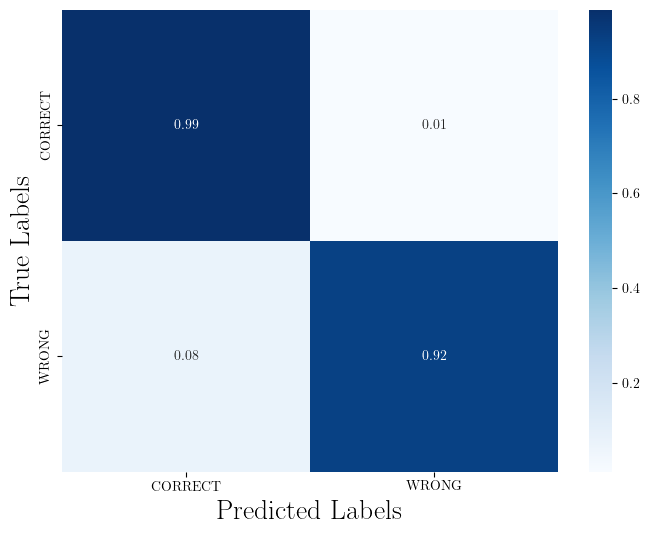

In [20]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='0.2f', cmap='Blues',
            xticklabels=['CORRECT', 'WRONG'],
            yticklabels=['CORRECT', 'WRONG'])
plt.xlabel('Predicted Labels', size=label_size)
plt.ylabel('True Labels', size=label_size)
if SAVE_FIGURES:
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'confusion-matrix_{BEST_MODEL}.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'confusion-matrix_{BEST_MODEL}.pdf'), dpi=300)
else:
    plt.title(f'Confusion Matrix for model:\n{renaming_rank_model_map[BEST_MODEL]}', size=16)
plt.show()


In [21]:

    
def get_group(row):
    _,row=row
    if row['human_tag'] and row['agree']:
        return "True Positive"
    if row['human_tag'] and not row['agree']:
        return "False Negative"
    if not row['human_tag'] and row['agree']:
        return "True Negative"
    if not row['human_tag'] and not row['agree']:
        return "False Positive"


plot_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

# plot_df = plot_df.loc[plot_df["task_type"]=="bAbI / open-ended"]



plot_df = plot_df.groupby(['agree', 'human_tag', "dataset_task", "task_type"]).agg(
        {
            'a-vert_correct_score' : 'mean',
            'a-vert_wrong_score' : 'mean',
        }
    ).reset_index()
plot_df['score_distance']=plot_df['a-vert_correct_score']-plot_df['a-vert_wrong_score']
plot_df['score_abs_distance']=np.abs(plot_df['score_distance'])
plot_df['group'] = [get_group(a) for a in plot_df.iterrows()]

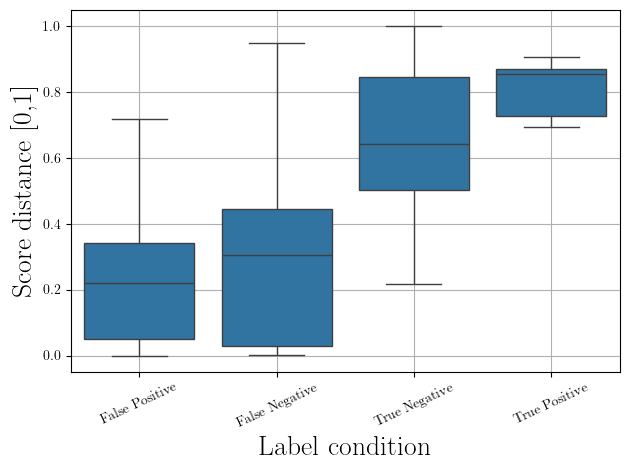

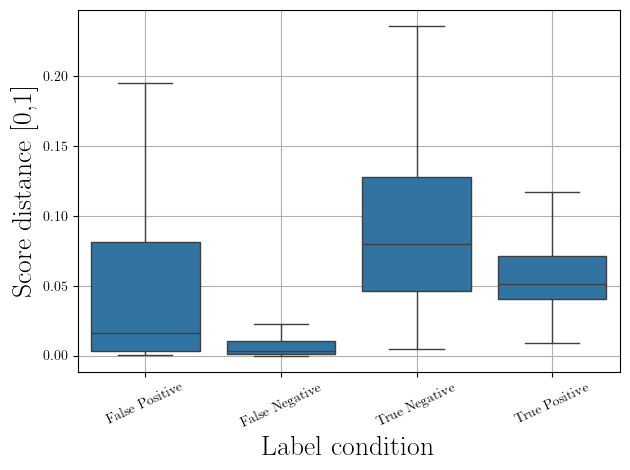

In [22]:
if not SAVE_FIGURES:
    plt.figure()  
for i, data_part in enumerate(["bAbI / open-ended", "MMLU / multiple-choice"]):
    plot_df2 = plot_df.loc[(plot_df["task_type"]==data_part)]
    # plot_df.boxplot(by='group', column =['score_distance'])
    if SAVE_FIGURES:
        plt.figure()  
        ax=plt.gca()
    else:
        ax=plt.subplot(1,2,i+1)
    sns.boxplot(data=plot_df2, x="group", y="score_abs_distance", ax=ax, showfliers=False)

    plt.grid()
    plt.xlabel("Label condition", size=label_size)
    plt.ylabel("Score distance [0,1]", size=label_size)
    plt.xticks(rotation=25)

    if SAVE_FIGURES:
        plt.draw()
        plt.tight_layout()
        if 'mmlu' in data_part.lower():
            plot_name = 'mmlu_dist_targets'
        else:
            plot_name = 'babi_dist_targets'
        plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'{plot_name}.png'))
        plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'{plot_name}.pdf'), dpi=300)
        plt.show()
    else:
        plt.title(data_part, size=title_size)


if not SAVE_FIGURES:
    plt.suptitle(f'Distance between scores for each result group\nModel:{BEST_MODEL}', size=title_size)
    plt.tight_layout()
    plt.show()



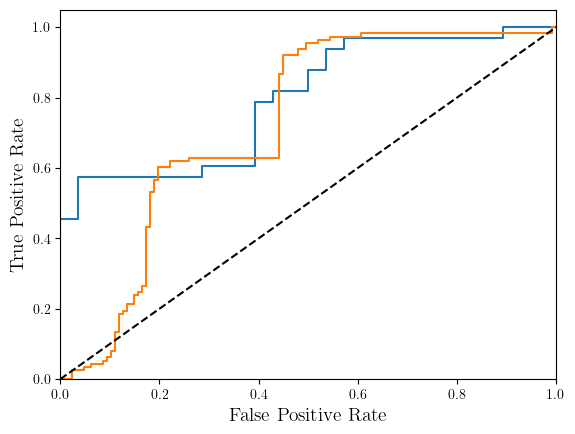

In [23]:
plt.figure()  
for data_part in ["bAbI / open-ended", "MMLU / multiple-choice"]:
    plot_df2 = plot_df.loc[(plot_df["task_type"]==data_part)]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(plot_df2['human_tag'], plot_df2['a-vert_correct_score']) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve

    plt.plot(fpr, tpr, label=f'{data_part} (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)

if SAVE_FIGURES:
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'ROC_{BEST_MODEL}.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'ROC_{BEST_MODEL}.pdf'), dpi=300)
else:
    plt.title(data_part, size=16)
    plt.title('ROC Curve', size=16)
    plt.legend()
plt.show()

# Approximate Token Usage

This is a very rough approximation not including thinking tokens.

In [24]:
plot_df = data_df.loc[(data_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (data_df["enhance"]==BEST_IS_ENHANCED) *\
                         (data_df["reranker"]==BEST_IS_RERANKER) *\
                         (data_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

In [25]:
plot_df.groupby(['language_model']).agg({"aprox_input_tokens" : "sum", "aprox_output_tokens": "sum"})
df_melt = plot_df.melt(id_vars = 'language_model',
                  value_vars = ['aprox_input_tokens', 'aprox_output_tokens'],
                  var_name = 'columns')

# remap language_model values
df_melt['language_model'] = df_melt['language_model'].map(rename_llm_model_map)

In [26]:
df_melt

,language_model,columns,value
0,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,17
1,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,26
2,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,35
3,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,44
4,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,54
...,...,...,...
54595,gpt-oss-20b,aprox_output_tokens,96
54596,gpt-oss-20b,aprox_output_tokens,201
54597,gpt-oss-20b,aprox_output_tokens,3
54598,gpt-oss-20b,aprox_output_tokens,153


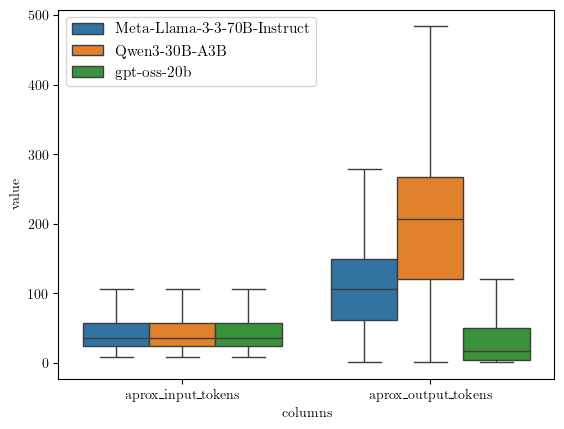

In [27]:

sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['aprox_input_tokens', 'aprox_output_tokens'],
                showfliers=False,
                legend=True)

plt.legend(loc='best', prop={'size': 11})
plt.show()

# SemScore Analysis

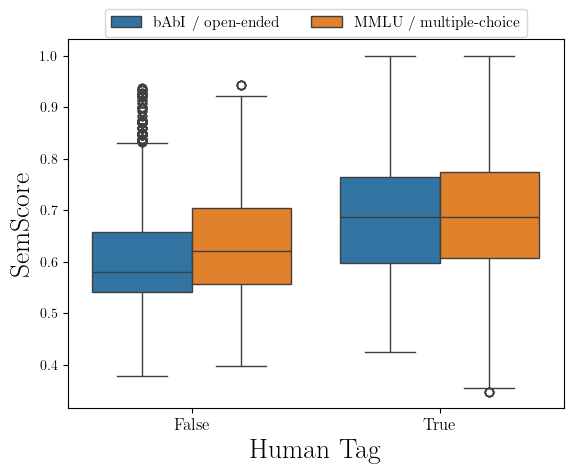

In [28]:
plt.figure()
# semscore_df = merged_df.loc[merged_df["embedding_model"].str.contains("Qwen3-Reranker-0.6B-seq-cls")] # This run calcualted semscore
semscore_df = merged_df.loc[(merged_df["semscore"] != 0)]
# semscore_df.boxplot(by='human_tag', column =['semscore'],)
# sns.violinplot(data=semscore_df, x="human_tag", y="semscore", hue="task_type")
sns.boxplot(data=semscore_df, x="human_tag", y="semscore", hue="task_type", legend=True)
# increase the ticks font size
plt.xticks(size=12)
plt.ylabel("SemScore", size=label_size)
plt.xlabel("Human Tag", size=label_size)

if SAVE_FIGURES:
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), prop={'size': 11})
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'semscore_boxplot.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'semscore_boxplot.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



In [29]:
# Calculate optimal threshold
opt_val = 0
thrs_opt = 0
for thrs in np.linspace(0.01,0.99,100):
    predicted_semscore = semscore_df['semscore'] > thrs
    opt = balanced_accuracy_score(semscore_df['human_tag'], predicted_semscore)
    if opt_val < opt:
        opt_val = opt
        thrs_opt = thrs
print(f"Optimal Threshold: {thrs_opt}\nBalanced Accuracy: {opt_val}")

Optimal Threshold: 0.6435353535353535
Balanced Accuracy: 0.6267698672068823


In [30]:
thrs = thrs_opt
predicted_semscore = semscore_df['semscore'] > thrs

# Calculate precision and recall
precision = precision_score(semscore_df['human_tag'], predicted_semscore)
recall = recall_score(semscore_df['human_tag'], predicted_semscore)
f1 = f1_score(semscore_df['human_tag'], predicted_semscore)
specificity = recall_score(1-semscore_df['human_tag'], 1-predicted_semscore)
balanced_accuracy = balanced_accuracy_score(semscore_df['human_tag'], predicted_semscore)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Precision: 0.89
Recall: 0.64
Specificity: 0.62
F1: 0.74
Balanced Accuracy: 0.63


# Baselines Comparisons

In [31]:
merged_to_compare_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]
grouped_to_compare_df = merged_to_compare_df.groupby(['language_model',	'dataset_task']).agg(
        {
            'human_tag' : "mean", 
            'a-vert_match': "mean",
            'agree': "mean"
        }
    ).reset_index().sort_values("agree")
grouped_to_compare_df.head()
# remane language_model by using rename_llm_model_map
grouped_to_compare_df["language_model"] = grouped_to_compare_df["language_model"].map(rename_llm_model_map)


### MMLU-Pro --- Completions + Logits

In [32]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "mmlu_pro_categories")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "mmlu_pro_categories", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "mmlu_pro-category-leaderboard" in key:
                    logits_rows.append([
                        lm_dir,
                        "mmlu_pro-category"+key.split("mmlu_pro-category-leaderboard")[-1],
                        obj["results"][key]["acc,none"]
                    ])

logits_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "acc_score"])
# rename language_model by using rename_llm_model_map
logits_df["language_model"] = logits_df["language_model"].map(rename_llm_model_map)

merged_logits_df = pd.merge(logits_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])

In [33]:
plt_df = deepcopy(merged_logits_df)
plt_df["Logprob Score"] = plt_df["acc_score"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Logprob Score', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

/tmp/ipykernel_117239/1218635081.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=label_size)


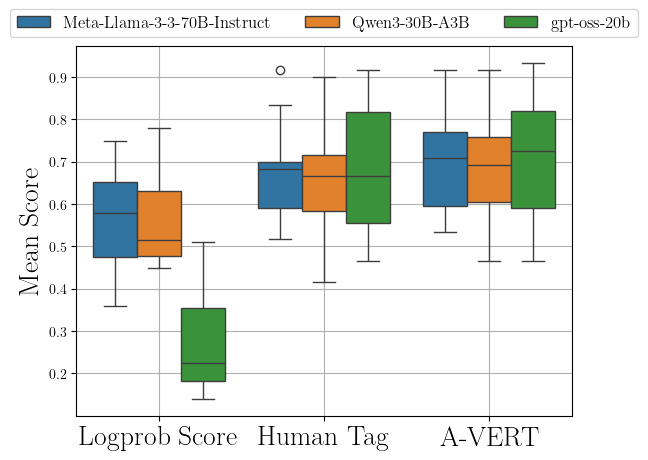

In [34]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Logprob Score', 'Human Tag', 'A-VERT'],
                legend=True )
# increase the ticks font size
g.set_xticklabels(g.get_xticklabels(), size=label_size)
plt.grid()

plt.xlabel("")
plt.ylabel("Mean Score", size=label_size)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3,
                prop={'size': 12})
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU-Pro Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [35]:
plot_df = merged_logits_df.loc[merged_logits_df["language_model"] != "gpt-oss-20b"]
# plot_df = merged_logits_df.loc[merged_logits_df["language_model"] == "Meta-Llama-3-3-70B-Instruct-AWQ-INT4"]
# plot_df = merged_logits_df.loc[merged_logits_df["language_model"] == "Qwen3-30B-A3B-GPTQ-Int4"]

plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['acc_score', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
plot_df["dataset_task"] = [a.split("mmlu_pro-category_")[-1] for a in plot_df["dataset_task"].values]
plot_df.head()

# plot_df["value"] += np.random.normal(0, 0.01, len(plot_df))

# rename 'acc_score` as 'Excact match' in scorer
mapping = {
    'acc_score': 'Logprob Score',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [36]:
logits_regression = deepcopy(plot_df)
logits_regression

,scorer,dataset_task,value
19,Logprob Score,engineering,0.415000
16,Logprob Score,chemistry,0.440000
33,Human Tag,engineering,0.466667
15,Logprob Score,business,0.470000
26,Logprob Score,physics,0.480000
23,Logprob Score,math,0.485000
8,A-VERT,law,0.500000
36,Human Tag,law,0.508333
24,Logprob Score,other,0.510000
5,A-VERT,engineering,0.533333


/tmp/ipykernel_117239/1155317817.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  scatter.set_xticklabels(scatter.get_xticklabels(), size=label_size)


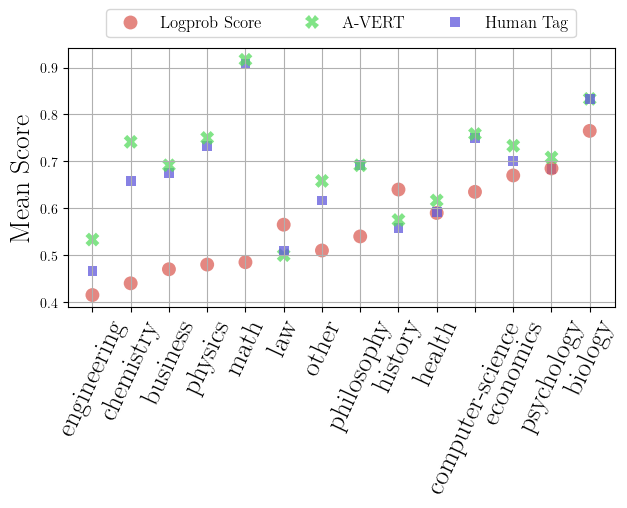

In [37]:
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Logprob Score', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Logprob Score', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.75,
                          linewidth=0,
                          legend=True
                          )
# pltylim(0.5,1.0)
plt.grid()
scatter.set_xticklabels(scatter.get_xticklabels(), size=label_size)
plt.xlabel("", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.xticks(rotation=65)
plt.tight_layout()

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0., ncol=3,fontsize=12)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of MMLU-Pro by-task scores\nfor the first 100 questions using different metrics.')

plt.show()

### bAbI --- Completions + Exact-Match

In [38]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "babi_tasks")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "babi_tasks", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "babi_tasks_completions" in key:
                    logits_rows.append([
                        lm_dir,
                        "babi-task_"+key.split("babi_tasks_completions-task_")[-1],
                        obj["results"][key]["exact_match,get_response"]
                    ])

babi_base_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "exact_match"])
# rename language_model by using rename_llm_model_map
babi_base_df["language_model"] = babi_base_df["language_model"].map(rename_llm_model_map)
merged_babi_base_df = pd.merge(babi_base_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])


In [39]:
plt_df = deepcopy(merged_babi_base_df)
plt_df["Exact Match"] = plt_df["exact_match"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Exact Match', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

In [40]:
df_melt

,language_model,columns,value
0,Meta-Llama-3-3-70B-Instruct,Exact Match,1.000000
1,Meta-Llama-3-3-70B-Instruct,Exact Match,0.880000
2,Meta-Llama-3-3-70B-Instruct,Exact Match,0.560000
3,Meta-Llama-3-3-70B-Instruct,Exact Match,0.970000
4,Meta-Llama-3-3-70B-Instruct,Exact Match,0.940000
...,...,...,...
175,gpt-oss-20b,A-VERT,0.033333
176,gpt-oss-20b,A-VERT,0.200000
177,gpt-oss-20b,A-VERT,1.000000
178,gpt-oss-20b,A-VERT,0.966667


/tmp/ipykernel_117239/842315977.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=14)


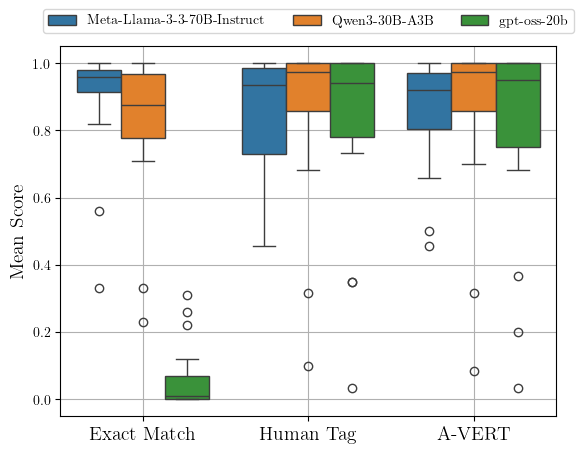

In [41]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Exact Match', 'Human Tag', 'A-VERT'],
                legend=SAVE_FIGURES
                   )
g.set_xticklabels(g.get_xticklabels(), size=14)
plt.grid()
plt.xlabel("")
plt.ylabel("Mean Score", size=14)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of bAbI Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [42]:
plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] != "gpt-oss-20b"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Meta-Llama-3-3-70B-Instruct-AWQ-INT4"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Qwen3-30B-A3B-GPTQ-Int4"]


plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['exact_match', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
if not SAVE_FIGURES:
  plot_df["dataset_task"] = [a.split("babi-task_")[-1] for a in plot_df["dataset_task"].values]
else:
  plot_df["dataset_task"] = [a.split("babi-task_")[-1].split("-")[0] for a in plot_df["dataset_task"].values]

In [43]:
mapping = {
    'exact_match': 'Exact Match',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [44]:
plot_df

,scorer,dataset_task,value
55,Human Tag,16,0.278571
38,Exact Match,19,0.280000
15,A-VERT,16,0.291667
2,A-VERT,03,0.386905
42,Human Tag,03,0.386905
22,Exact Match,03,0.445000
59,Human Tag,20,0.691667
1,A-VERT,02,0.764286
56,Human Tag,17,0.772619
41,Human Tag,02,0.780952


In [45]:
exact_match_regression = deepcopy(plot_df)

/tmp/ipykernel_117239/1924658836.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  scatter.set_xticklabels(new_xticks, size=12)


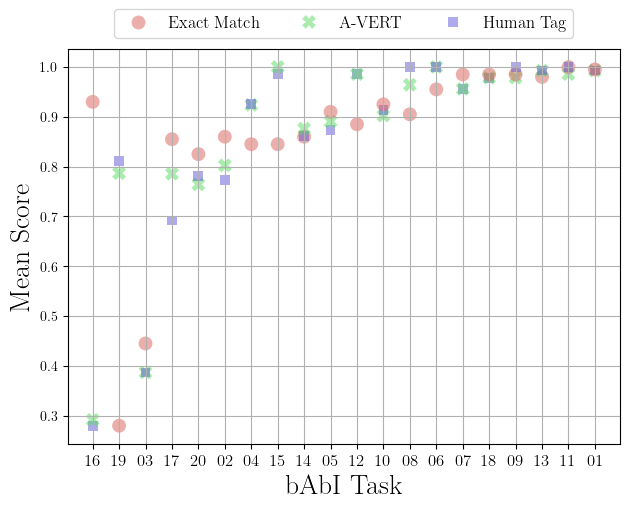

In [46]:
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.5,
                          linewidth=0,
                          legend=True
                          )
# pltylim(0.5,1.0)
new_xticks = [
"16",
"19",
"03",
"17",
"20",
"02",
"04",
"15",
"14",
"05",
"12",
"10",
"08",
"06",
"07",
"18",
"09",
"13",
"11",
"01"
]
scatter.set_xticklabels(new_xticks, size=12)
plt.grid()
plt.xlabel("bAbI Task", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.tight_layout()

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.10), loc='upper center', borderaxespad=0., ncol=3,fontsize=12)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of bAbI Scores by-task\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xticks(rotation=90)
    
plt.show()

### MMLU --- Chat-Completions + Exact-Match

In [47]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "mmlu_generative")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "mmlu_generative", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "mmlu_" in key:
                    logits_rows.append([
                        lm_dir,
                        "mmlu_"+key.split("mmlu_")[-1].split("_generative")[0]+ "_chat_generative",
                        obj["results"][key]["exact_match,get_response"]
                    ])

mmlu_base_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "exact_match"])
# rename language_model by using rename_llm_model_map
mmlu_base_df["language_model"] = mmlu_base_df["language_model"].map(rename_llm_model_map)

merged_mmlu_base_df = pd.merge(mmlu_base_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])


In [48]:
plt_df = deepcopy(merged_mmlu_base_df)
plt_df["Exact Match"] = plt_df["exact_match"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Exact Match', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

/tmp/ipykernel_117239/2163180875.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=label_size*0.9)


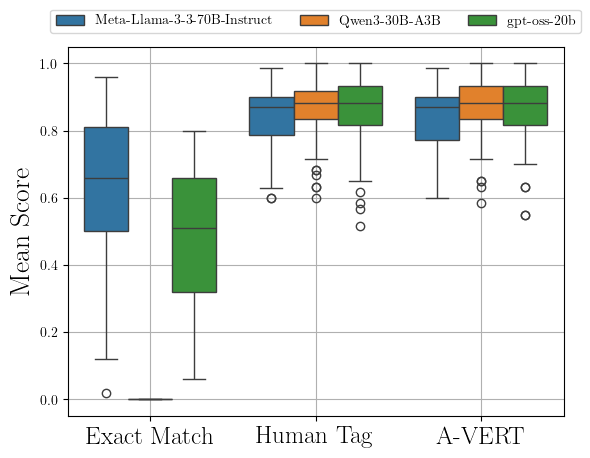

In [49]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Exact Match', 'Human Tag', 'A-VERT'],
                legend=True
                   )

g.set_xticklabels(g.get_xticklabels(), size=label_size*0.9)
plt.grid()

plt.xlabel("")
plt.ylabel("Mean Score", size=label_size)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [50]:
plot_df = merged_mmlu_base_df.loc[merged_mmlu_base_df["language_model"] != "Qwen3-30B-A3B"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Meta-Llama-3-3-70B-Instruct"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "gpt-oss-20b"]


plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['exact_match', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
plot_df["dataset_task"] = [a.split("mmlu_")[-1].split("_chat_generative")[0] for a in plot_df["dataset_task"].values]
plot_df.head()

,scorer,dataset_task,value
74,exact_match,global_facts,0.135
112,exact_match,virology,0.185
84,exact_match,high_school_physics,0.230
82,exact_match,high_school_mathematics,0.230
63,exact_match,college_chemistry,0.250


In [51]:
mapping = {
    'exact_match': 'Exact Match',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [52]:
exact_match_regression = pd.concat([exact_match_regression, plot_df])

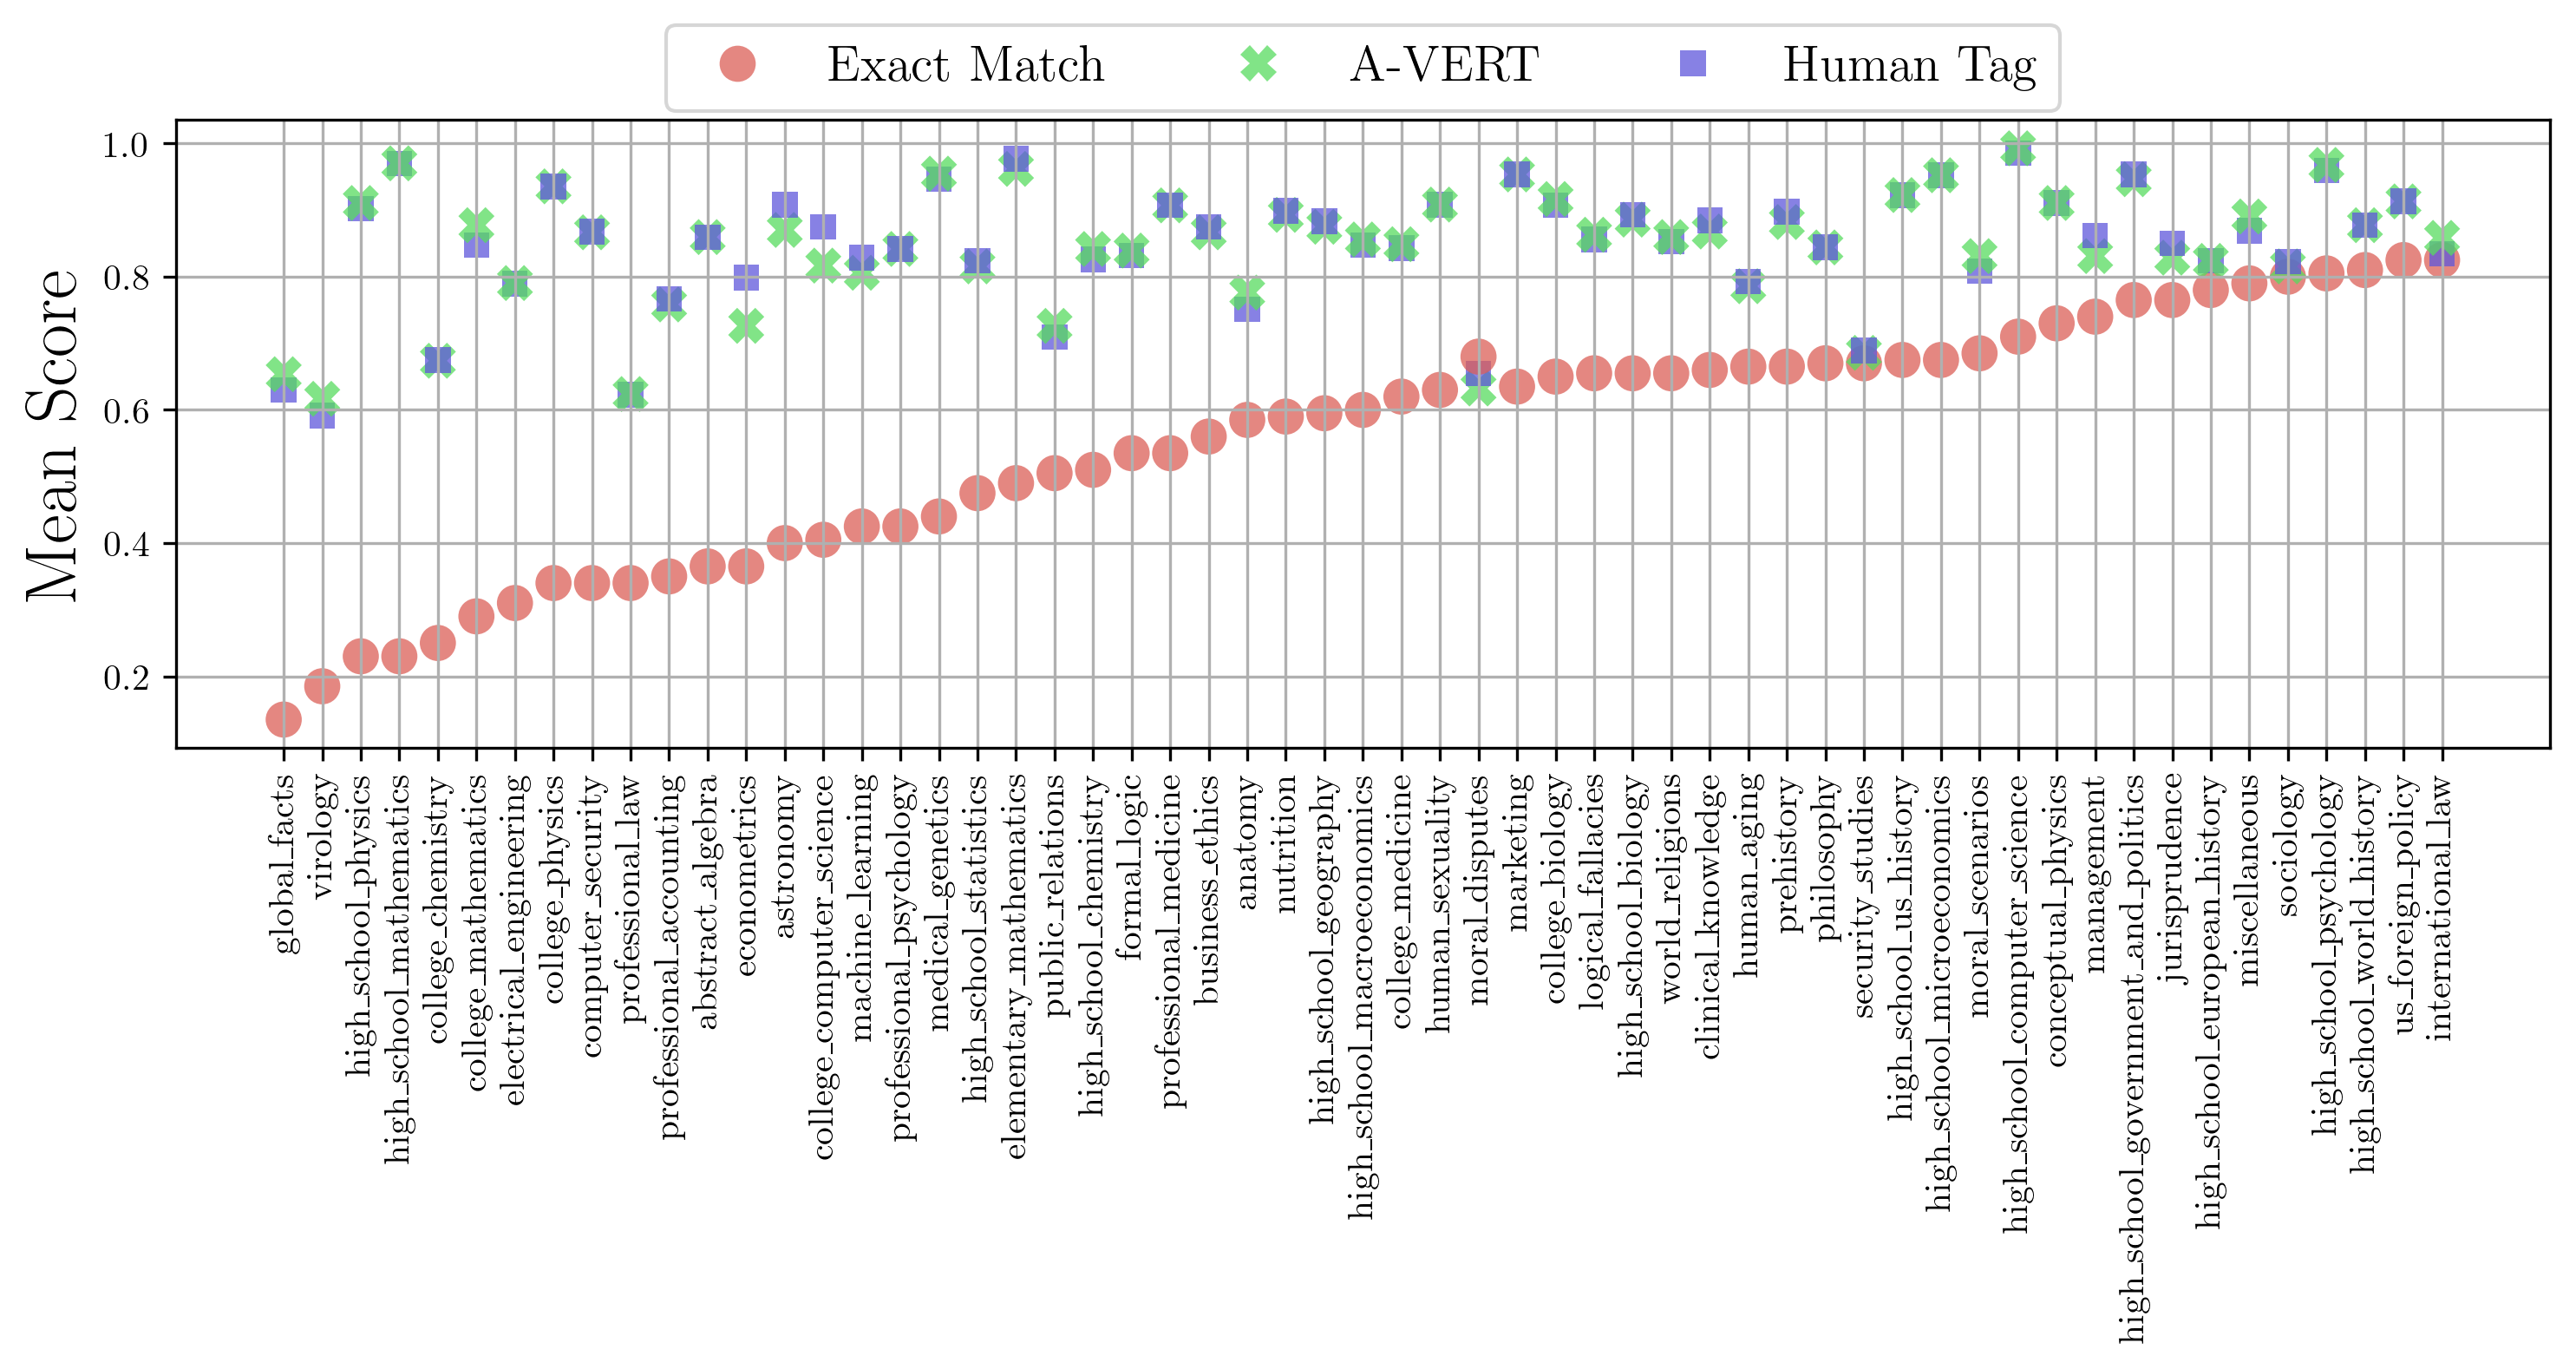

In [53]:
plt.figure(figsize=(10, 5), dpi=300)
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.75,
                          linewidth=0,
                          legend=True
                          )
# pltylim(0.5,1.0)
plt.grid()
plt.xlabel("", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.xticks(rotation=90)
plt.tight_layout()

if SAVE_FIGURES:
    #plt.legend(loc='upper right', borderaxespad=0., ncol=1, fontsize=12, bbox_to_anchor=(1.2, 1))
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0., ncol=3,fontsize=14)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU Scores by-task\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  
plt.show()

In [54]:
def result_plot(y_test, y_pred, lim_pred, color='b', marker='s', score='A-VERT'):
    from sklearn import linear_model
    from sklearn.metrics import r2_score

    regr = linear_model.LinearRegression()
    regr.fit(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    r2 = np.round(r2_score(y_true=y_test.reshape(-1,1),y_pred=y_pred.reshape(-1,1)),3)
    print('R2_{}: {:.3f}'.format(score,r2,))

    lin_x_pred = np.arange(2*lim_pred[0], lim_pred[1]*2, dtype=float)
    lin_y_pred = regr.predict(lin_x_pred.reshape(-1,1))
    
    f, ax = plt.subplots()
    # Identity (at the back, z=0)
    ax.plot([-1, 2], [-1, 2], color='r', label='Identity', linewidth=2, zorder=0)
    # Scatter
    ax.scatter(y_test, y_pred,c=color,marker=marker,label=score,alpha=0.5, zorder=5)
    # Linear regression
    ax.plot(lin_x_pred, lin_y_pred, color='k',label='R2={}'.format(r2), linewidth=1, linestyle='--', zorder=10)

    ax.set_xlabel('Human Tag', fontsize=label_size)
    ax.set_ylabel(score+' score', fontsize=label_size)
    #ax.set_title('Sub-tasks comparison',fontsize=24)
    # legend
    ax.legend(loc='upper left', fontsize=12)
    # add grid
    ax.grid(True)
    plt.xlim(lim_pred)
    plt.ylim(lim_pred)

    return(f, ax)

# Regression Analysis
## Exact-Match vs A-VERT

In [55]:
pivot_df_em = pd.pivot_table(exact_match_regression, index='dataset_task', columns='scorer', values='value')
pivot_df_em.reset_index(inplace=True)
pivot_df_em

scorer,dataset_task,A-VERT,Exact Match,Human Tag
0,01,0.985714,1.000,1.000000
1,02,0.764286,0.825,0.780952
2,03,0.386905,0.445,0.386905
3,04,0.923810,0.845,0.925000
4,05,0.890476,0.910,0.873810
...,...,...,...,...
72,security_studies,0.685714,0.670,0.689286
73,sociology,0.815476,0.800,0.822619
74,us_foreign_policy,0.913095,0.825,0.913095
75,virology,0.616667,0.185,0.591667


R2_A-VERT: 0.974


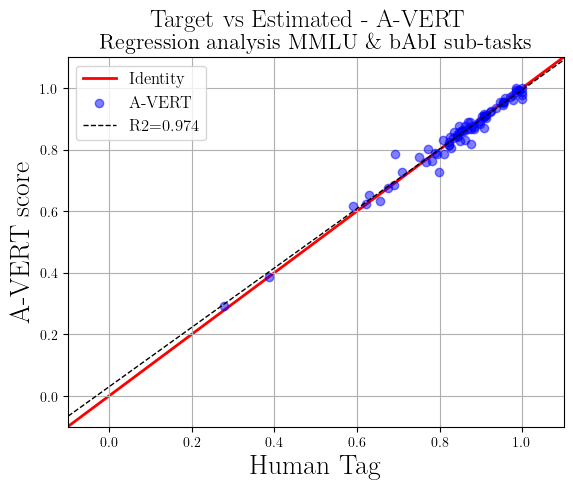

R2_Exact Match: -4.902


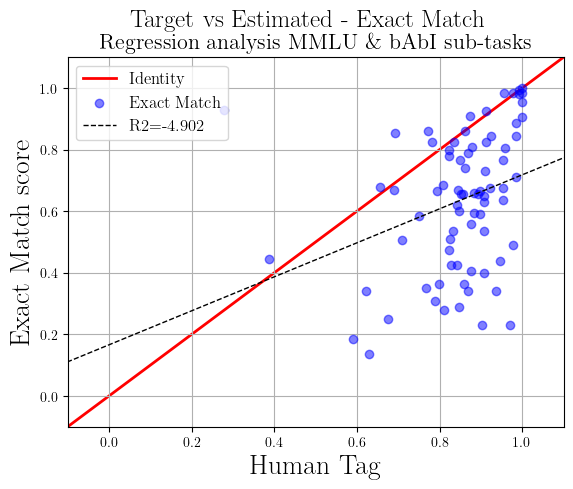

In [56]:
f, ax = result_plot(
    y_test=pivot_df_em["Human Tag"].values,
    y_pred=pivot_df_em["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')

ax.set_title('Regression analysis MMLU \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_avert.pdf'), bbox_inches='tight')
plt.show()

f, ax = result_plot(
    y_test=pivot_df_em["Human Tag"].values,
    y_pred=pivot_df_em["Exact Match"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='Exact Match')
ax.set_title('Regression analysis MMLU \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - Exact Match', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_exactmatch.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_exactmatch.pdf'), bbox_inches='tight')
plt.show()

## Logits Score vs A-VERT

In [57]:
pivot_df_ls = pd.pivot_table(logits_regression, index='dataset_task', columns='scorer', values='value')
pivot_df_ls.reset_index(inplace=True)
pivot_df_ls

scorer,dataset_task,A-VERT,Human Tag,Logprob Score
0,biology,0.833333,0.833333,0.765
1,business,0.691667,0.675000,0.470
2,chemistry,0.741667,0.658333,0.440
3,computer-science,0.758333,0.750000,0.635
4,economics,0.733333,0.700000,0.670
5,engineering,0.533333,0.466667,0.415
6,health,0.616667,0.591667,0.590
7,history,0.575000,0.558333,0.640
8,law,0.500000,0.508333,0.565
9,math,0.916667,0.908333,0.485


R2_A-VERT: 0.910


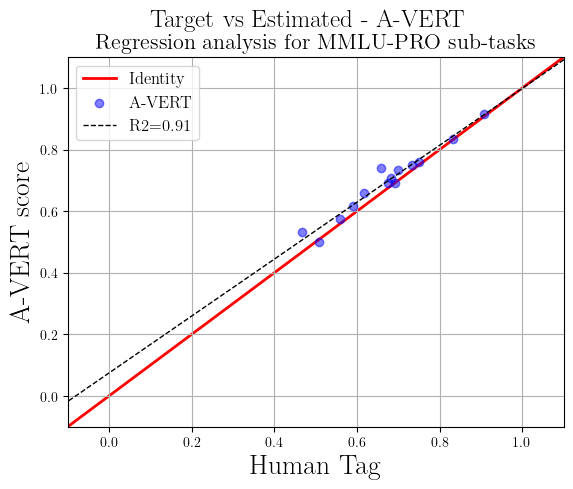

R2_Logprob: -1.161


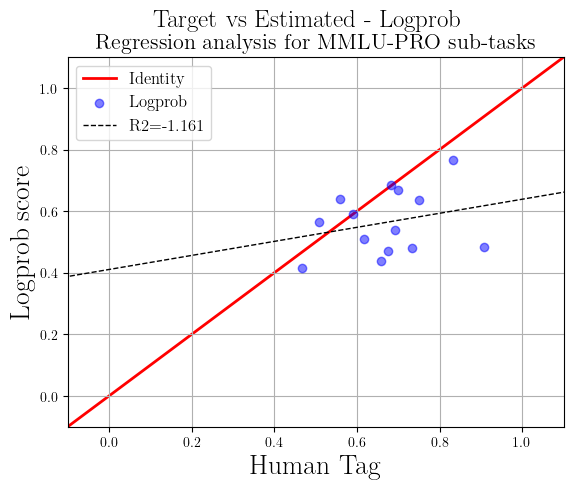

In [58]:
f, ax = result_plot(
    y_test=pivot_df_ls["Human Tag"].values,
    y_pred=pivot_df_ls["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')
ax.set_title('Regression analysis for MMLU-PRO sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_avert.pdf'), dpi=300, bbox_inches='tight')
plt.show()


f, ax = result_plot(
    y_test=pivot_df_ls["Human Tag"].values,
    y_pred=pivot_df_ls["Logprob Score"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='Logprob')
ax.set_title('Regression analysis for MMLU-PRO sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - Logprob', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_logits.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_logits.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [59]:
pivot_df_ls

scorer,dataset_task,A-VERT,Human Tag,Logprob Score
0,biology,0.833333,0.833333,0.765
1,business,0.691667,0.675000,0.470
2,chemistry,0.741667,0.658333,0.440
3,computer-science,0.758333,0.750000,0.635
4,economics,0.733333,0.700000,0.670
5,engineering,0.533333,0.466667,0.415
6,health,0.616667,0.591667,0.590
7,history,0.575000,0.558333,0.640
8,law,0.500000,0.508333,0.565
9,math,0.916667,0.908333,0.485


# Overall Regression Analysis

In [60]:
# concatenate A-VERT and Human Tag columns
overall_comparison_df = pd.concat([
    pivot_df_em[['dataset_task', 'A-VERT', 'Human Tag']],
    pivot_df_ls[['dataset_task', 'A-VERT', 'Human Tag']]
], axis=0)

R2_A-VERT: 0.973


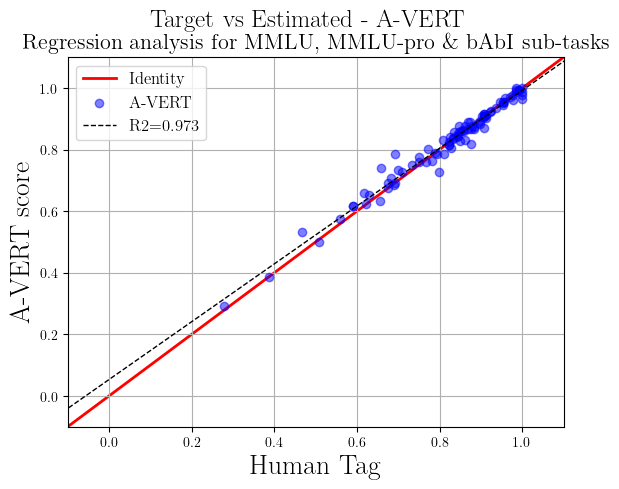

In [61]:
f, ax = result_plot(
    y_test=overall_comparison_df["Human Tag"].values,
    y_pred=overall_comparison_df["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')
ax.set_title('Regression analysis for MMLU, MMLU-pro \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'overall_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'overall_regression_avert.pdf'), dpi=300, bbox_inches='tight')
plt.show()